Combine all outputs across multiple imaging batches into a single file and produce segmentation projections for manual evaluation

In [1]:
#### ADD CUSTOM PATH ###
path_to_quant = '//home/gridsan/djuna/homer/github/confocalQuant'

In [2]:
import sys
import os
from tqdm import tqdm 
from aicsimageio import AICSImage
from cellpose import models
import numpy as np
import pandas as pd
import numpy as np
import glob
from skimage.segmentation import find_boundaries
from PIL import Image

sys.path.append(path_to_quant)
from confocalQuant.segmentation import get_czi_files, hide_masks, gamma_correct_image, extract_channels, float_to_int
from confocalQuant.plotting import get_out_files, add_metadata, is_string_present, return_results, filter_data, get_id_data
from confocalQuant.quantification import concatenate_Y
from confocalQuant.image import save_mean_proj

/home/gridsan/djuna/.local/lib/python3.8/site-packages/pydantic/_migration.py:281: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


In [74]:
def norm_value(all_data, value, norm):
    all_data[value+'_per_point'] = all_data[value]/all_data[norm]
    
def get_per_batch_data(parent_path, in_dirs, out_dirs, ID, target_vals):
    # concatenate image metadata
    im_path_root = parent_path + 'data/' + in_dirs[ID]
    out_path_root = parent_path + 'outs/' + out_dirs[ID]

    in_file_names = get_czi_files(im_path_root)
    out_file_names = get_out_files(out_path_root)

    df = pd.DataFrame([x.split('.')[0] for x in in_file_names])
    df.columns = ['filename']
    df['ID'] = range(len(in_file_names))
    df['batch'] = in_dirs[ID]
    wellname = [x.split('-')[0] for x in df['filename']]
    df['well_name'] = wellname
    dictionary = dict(zip([int(x.split('_')[1].split('.')[0]) for x in out_file_names], out_file_names))
    df['slurm_name'] = [dictionary[x] for x in df['ID']]

    add_metadata(df, im_path_root+'/temp.csv')

    # get the actual data

    path_to_sbatch_file = glob.glob(out_path_root+'/'+'*.sbatch')[0]
    mat, masks, Y, Ncells, Nzi, cells_per_job, zi_per_job, randID_per_job = return_results(path_to_sbatch_file, '../../')
    df['randID'] = randID_per_job

    # concatenate Y data
    colnames = colnames_dict[in_dirs[ID]]
    Nfiles = df.shape[0]
    Y_extracted = concatenate_Y(Nfiles, Y, cells_per_job, Ncells, colnames)

    all_data = pd.merge(df, Y_extracted, on='ID')
    norm_value(all_data, 'DAPI', 'Npoints')
    norm_value(all_data, 'NeuN', 'Npoints')
    for i in range(len(target_vals)):
        norm_value(all_data, target_vals[i], 'Npoints')
    
    return all_data

In [75]:
# prep
parent_path = '/home/gridsan/djuna/homer/github/confocalQuant/'
dirs = np.array(os.listdir('../'))
out_dirs = dirs[['neuron' in x for x in dirs]]
in_dirs = [x.split('_out')[0] for x in out_dirs]

colnames = pd.read_csv('colnames.csv')
colnames_dict = dict(zip(list(colnames['batch']), ([[x.split("'")[1] for x in y.split(',')] for y in colnames['colnames']])))

In [73]:
colnames_dict[in_dirs[4]]

['DAPI',
 'NeuN',
 'Tuj',
 'mito',
 'cellvolume',
 'Npoints',
 'Tuj-b',
 'mito-b',
 'ID']

In [81]:
all_data = get_per_batch_data(parent_path, in_dirs, out_dirs, -2, ['mito-b'])

In [82]:
# save all data
all_data.to_csv('./out_data/'+in_dirs[-2]+'_data.csv', index = False)

## below is scrap

In [53]:
pd.concat(all_data, pd.concat([all_data[x]/all_data['Npoints'] for x in ['DAPI', 'NeuN', 'mito-b']], axis=1)

/state/partition1/slurm_tmp/24464380.0.0/ipykernel_2654113/3217969252.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  pd.concat(all_data, pd.concat([all_data[x]/all_data['Npoints'] for x in ['DAPI', 'NeuN', 'mito-b']], axis=1), axis=1)


TypeError: concat() got multiple values for argument 'axis'

In [35]:
colnames_dict

{'neuronbatch09062023_cellrox_neuN': ['DAPI',
  'NeuN',
  'Tuj',
  'cellrox',
  'cellvolume',
  'Npoints',
  'Tuj-b',
  'cellrox-b',
  'ID'],
 'neuronbatch09062023_mitohealth_neuN': ['DAPI',
  'NeuN',
  'Tuj',
  'mito',
  'cellvolume',
  'Npoints',
  'Tuj-b',
  'mito-b',
  'ID'],
 'neuronbatch10132023_cellrox': ['DAPI',
  'NeuN',
  'Tuj',
  'cellrox',
  'cellvolume',
  'Npoints',
  'Tuj-b',
  'cellrox-b',
  'ID'],
 'neuronbatch10132023_mitohealth': ['DAPI',
  'NeuN',
  'Tuj',
  'mito',
  'cellvolume',
  'Npoints',
  'Tuj-b',
  'mito-b',
  'ID'],
 'neuronbatch101823_cellrox': ['DAPI',
  'NeuN',
  'cellrox',
  'cellvolume',
  'Npoints',
  'cellrox-b',
  'ID'],
 'neuronbatch101823_mitohealth': ['DAPI',
  'NeuN',
  'mito',
  'cellvolume',
  'Npoints',
  'mito-b',
  'ID'],
 'neuronbatch102523_cellrox': ['DAPI',
  'NeuN',
  'cellrox',
  'cellvolume',
  'Npoints',
  'cellrox-b',
  'ID'],
 'neuronbatch102523_mito': ['DAPI',
  'NeuN',
  'mito',
  'cellvolume',
  'Npoints',
  'mito-b',
  'ID'],


In [30]:
    # extract Y per batch
colnames = colnames_dict[batch]
    Y_extracted = concatenate_Y(Nfiles, Y, cells_per_job, Ncells, colnames)

,filename,ID,batch,well_name,slurm_name,treatment,line,job_done,randID
0,B03-1,0,neuronbatch11082023_mitohealth,B03,slurm-24462267_0.out,vehicle,E3,True,3546248239
1,B03-2,1,neuronbatch11082023_mitohealth,B03,slurm-24462267_1.out,vehicle,E3,True,9577843435
2,B04-1,2,neuronbatch11082023_mitohealth,B04,slurm-24462267_2.out,CDP-choline,E3,True,1794921487
3,B05-1,3,neuronbatch11082023_mitohealth,B05,slurm-24462267_3.out,CDP-choline,E3,True,9893695640
4,B06-1,4,neuronbatch11082023_mitohealth,B06,slurm-24462267_4.out,sn-glycero-3-phosphocholine,E3,True,8969831272
...,...,...,...,...,...,...,...,...,...
67,G09-1,67,neuronbatch11082023_mitohealth,G09,slurm-24462267_67.out,rosiglitazone,G2,True,8901905755
68,G10-1,68,neuronbatch11082023_mitohealth,G10,slurm-24462267_68.out,GW501516,G2,True,3301945500
69,G10-2,69,neuronbatch11082023_mitohealth,G10,slurm-24462267_69.out,GW501516,G2,True,7854011499
70,G11-1,70,neuronbatch11082023_mitohealth,G11,slurm-24462267_70.out,DGAT1/2i,G2,True,9946691864


In [21]:
res = []
for i in tqdm(range(df.shape[0])):
    file = '../'+df['batch'][i]+'_out/' + df['slurm_name'][i]
    res.append(is_string_present(file, 'done'))

df['job_done'] = res

100%|██████████| 72/72 [00:01<00:00, 51.04it/s]


In [22]:
df

,filename,ID,batch,well_name,slurm_name,treatment,line,job_done
0,B03-1,0,neuronbatch11082023_mitohealth,B03,slurm-24462267_0.out,vehicle,E3,True
1,B03-2,1,neuronbatch11082023_mitohealth,B03,slurm-24462267_1.out,vehicle,E3,True
2,B04-1,2,neuronbatch11082023_mitohealth,B04,slurm-24462267_2.out,CDP-choline,E3,True
3,B05-1,3,neuronbatch11082023_mitohealth,B05,slurm-24462267_3.out,CDP-choline,E3,True
4,B06-1,4,neuronbatch11082023_mitohealth,B06,slurm-24462267_4.out,sn-glycero-3-phosphocholine,E3,True
...,...,...,...,...,...,...,...,...
67,G09-1,67,neuronbatch11082023_mitohealth,G09,slurm-24462267_67.out,rosiglitazone,G2,True
68,G10-1,68,neuronbatch11082023_mitohealth,G10,slurm-24462267_68.out,GW501516,G2,True
69,G10-2,69,neuronbatch11082023_mitohealth,G10,slurm-24462267_69.out,GW501516,G2,True
70,G11-1,70,neuronbatch11082023_mitohealth,G11,slurm-24462267_70.out,DGAT1/2i,G2,True


### 1. Create metadata file

In [4]:
parent_path = '/home/gridsan/djuna/homer/github/confocalQuant/'
dirs = np.array(os.listdir('../'))
out_dirs = dirs[['neuron' in x for x in dirs]]
in_dirs = [x.split('_out')[0] for x in out_dirs]

In [ ]:
print(in_dirs)

In [5]:
# combine all file info
all_data = []

for i in tqdm(range(len(in_dirs))):
    im_path_root = parent_path + 'data/' + in_dirs[i]
    out_path_root = parent_path + 'outs/' + out_dirs[i]
    
    in_file_names = get_czi_files(im_path_root)
    out_file_names = get_out_files(out_path_root)
    
    df = pd.DataFrame([x.split('.')[0] for x in in_file_names])
    df.columns = ['filename']
    df['ID'] = range(len(in_file_names))
    df['batch'] = in_dirs[i]
    wellname = [x.split('-')[0] for x in df['filename']]
    df['well_name'] = wellname
    dictionary = dict(zip([int(x.split('_')[1].split('.')[0]) for x in out_file_names], out_file_names))
    df['slurm_name'] = [dictionary[x] for x in df['ID']]
    
    add_metadata(df, im_path_root+'/temp.csv')
    
    all_data.append(df)
    
im_data = pd.DataFrame(np.vstack(all_data))
im_data.columns = ['filename', 'fileID', 'batch', 'well_name', 'slurm_file', 'treatment', 'line']

100%|██████████| 12/12 [00:00<00:00, 31.16it/s]


In [6]:
im_data.head()

,filename,fileID,batch,well_name,slurm_file,treatment,line
0,C10,0,neuronbatch10132023_cellrox,C10,slurm-24409544_0.out,DGATi,Y622
1,C2,1,neuronbatch10132023_cellrox,C2,slurm-24409544_1.out,vehicle,Y622
2,C3,2,neuronbatch10132023_cellrox,C3,slurm-24409544_2.out,vehicle,Y622
3,C4,3,neuronbatch10132023_cellrox,C4,slurm-24409544_3.out,CDP-choline,Y622
4,C5,4,neuronbatch10132023_cellrox,C5,slurm-24409544_4.out,CDP-choline,Y622


In [7]:
# add info on whether job finished runnning
res = []
for i in tqdm(range(im_data.shape[0])):
    file = '../'+im_data['batch'][i]+'_out/' + im_data['slurm_file'][i]
    res.append(is_string_present(file, 'done'))

im_data['job_done'] = res

100%|██████████| 529/529 [00:11<00:00, 47.43it/s]


In [8]:
# add unique image ID
np.random.seed(5)
im_data['unique_image_ID'] = [np.random.randint(10**9, 10**10) for x in range(im_data.shape[0])]

In [9]:
# a few checks
im_data[np.invert(im_data['job_done'])]
random_10_digit_number = im_data['unique_image_ID']
len(np.unique(random_10_digit_number))==len(random_10_digit_number)

True

In [10]:
# add 'keep' column to populate later
im_data['keep'] = np.nan

In [11]:
np.unique(im_data['job_done'], return_counts=True)

(array([ True]), array([529]))

In [12]:
im_data[im_data['job_done']==False]

,filename,fileID,batch,well_name,slurm_file,treatment,line,job_done,unique_image_ID,keep


In [13]:
im_data = im_data[[x in set(['neuronbatch11082023_cellrox_bodipy']) for x in im_data['batch']]]

In [20]:
im_data[im_data['unique_image_ID']==5003688641]

,filename,fileID,batch,well_name,slurm_file,treatment,line,job_done,unique_image_ID,keep
321,D10-1,28,neuronbatch11082023_cellrox_bodipy,D10,slurm-24454254_28.out,GW501516,Y622,True,5003688641,NaN


In [22]:
np.percentile([0,0,0.5], 100)

0.5

### 2. add the Y_data to this datatable

100%|██████████| 68/68 [04:06<00:00,  3.62s/it]


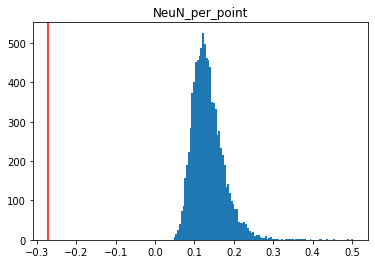

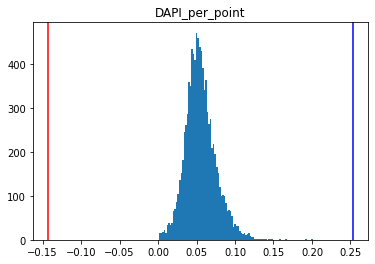

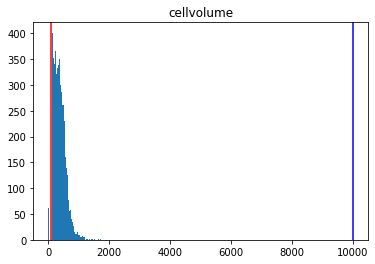

In [17]:
# make dictionaries
x, y = np.unique(im_data['batch'], return_counts=True)
Nfiles_dict = dict(zip(x,y))
batches = np.unique(im_data['batch'])
colnames = pd.read_csv('colnames.csv')
colnames_dict = dict(zip(list(colnames['batch']), ([[x.split("'")[1] for x in y.split(',')] for y in colnames['colnames']])))
list_of_dfs = [(_, group) for _, group in im_data.groupby('batch')]
id_dicts = [dict(zip(x[1]['fileID'], x[1]['unique_image_ID'])) for x in list_of_dfs]
names = [x[0] for x in list_of_dfs]
id_dicts_per_batch = dict(zip(names, id_dicts))

# concat per cell Y info
res = []
start = 0
end = 0
s_index = np.empty(im_data.shape[0])
e_index = np.empty(im_data.shape[0])
im_index = 0

for i in (range(len(batches))):
    
    # load data per batch
    batch = batches[i]
    directory = '../' + batch +'_out/'
    path_to_sbatch_file = glob.glob(directory+'*.sbatch')[0]
    mat, masks, Y, Ncells, Nzi, cells_per_job, zi_per_job = return_results(path_to_sbatch_file,  '../../')
   
    # extract Y per batch
    Nfiles = Nfiles_dict[batch]
    colnames = colnames_dict[batch]
    Y_extracted = concatenate_Y(Nfiles, Y, cells_per_job, Ncells, colnames)
    id_d = id_dicts_per_batch[batch]
    Y_extracted['unique_image_ID'] = [id_d[int(x)] for x in Y_extracted['ID']]
    Y_extracted['NeuN_per_point'] = Y_extracted['NeuN']/Y_extracted['Npoints']
    Y_extracted['DAPI_per_point'] = Y_extracted['DAPI']/Y_extracted['Npoints']

    # filter and append Y per batch
    Y_filtered = filter_data(Y_extracted, 'NeuN_per_point', 'DAPI_per_point', 'cellvolume', 'wellname', lower_thresh_vol = 100, upper_thresh_vol = 10000, C_nuc=10, C_soma=10, C_nuc_upper=10, plot=True)
    Y_extracted['keep_cell'] = [x in set(Y_filtered.index) for x in Y_extracted.index]
    res.append(Y_extracted)
    
    # plot image per ID per batch
    IDs = list(id_d.keys())
    for ID in tqdm(range(len(IDs))):
        save_mean_proj(ID, zi_per_job, Nzi, mat, masks, Y_extracted, Y_filtered, id_d)
    

# concatenate across all batches
cell_data = pd.concat(res, ignore_index=True)


In [17]:
cell_data.to_csv('./cell_data_only1108.csv')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/pandas/core/internals/blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


In [ ]:
# upload images to labelbox.com to determine which images to keep 


In [ ]:
find ./segmentations -type f -newermt 2023-12-01 ! -newermt 2023-01-02 -exec tar -rvf output_files_created_on_2023-01-01.tar.gz {} +
